In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import arviz as az
from scipy.stats import binom

import inference_pytorch.utils as iut

In [20]:
## Matplotlib parameters
save_fig = False

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [21]:
input_dir = '/mnt/home/bregaldosaintblancard/ceph/diffusion4dust/sbc_ruben/'

n_chains_per_sample = 4
norm_phi_mode = 'compact' # For alpha only, since sigma is not normalized
sigma_min, sigma_max = 0.1, 0.8
nparams = 2 # alpha, sigma
burnin = 31

In [22]:
#
# Load SBC data
#

files_list = os.listdir(input_dir)
phi_all_f_list = [f for f in files_list if f.endswith('_phi_all_v7.pt')]
phi_true_f_list = [f for f in files_list if f.endswith('_phi_true_v7.pt')]
phi_all_f_list.sort()
phi_true_f_list.sort()

NM, _ = torch.load(os.path.join(input_dir, phi_true_f_list[0])).shape
N = NM // n_chains_per_sample
M = n_chains_per_sample

phi_all_list = []
phi_true_list = []
for i in range(len(phi_all_f_list)):
    print('Loading file %s' % phi_all_f_list[i])
    print('Loading file %s' % phi_true_f_list[i])
    phi_all_list.append(torch.load(os.path.join(input_dir, phi_all_f_list[i])).detach().reshape(M, N, -1, nparams))
    phi_true_list.append(torch.load(os.path.join(input_dir, phi_true_f_list[i])).detach().reshape(M, N, nparams))
phi_all = torch.cat(phi_all_list, dim=1).transpose(0, 1)
phi_true = torch.cat(phi_true_list, dim=1).transpose(0, 1)

N, M = phi_all.shape[:2]
print('N = %d, M = %d' % (N, M))

Loading file id_0_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_0_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_10_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_10_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_11_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_11_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_12_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_12_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_13_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_13_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_14_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_14_nsamples_40_nchains_4_phi_true_v7.pt


Loading file id_15_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_15_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_16_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_16_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_17_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_17_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_18_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_18_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_19_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_19_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_1_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_1_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_2_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_2_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_3_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_3_nsamples_40_nchains_4_phi_true_v7.pt
Loading file id_4_nsamples_40_nchains_4_phi_all_v7.pt
Loading file id_4_nsamples_40_nchains_4_phi_true_v7.pt
Loading f

In [23]:
# Unnormalize phi
phi_all[..., 0] = iut.unnormalize_phi(phi_all[..., 0], mode=norm_phi_mode)
phi_true[..., 0] = iut.unnormalize_phi(phi_true[..., 0], mode=norm_phi_mode)
phi_all = phi_all.cpu().numpy()[:, :,  burnin:, :]
phi_true = phi_true.cpu().numpy()

In [24]:
# Compute ESS and Rhat
ess = np.zeros((N, nparams))
rhat = np.zeros((N, nparams))

for i in range(N):
    az_infdata = az.convert_to_inference_data(phi_all[i])
    ess[i] = az.ess(az_infdata)['x'].values
    rhat[i] = az.rhat(az_infdata)['x'].values

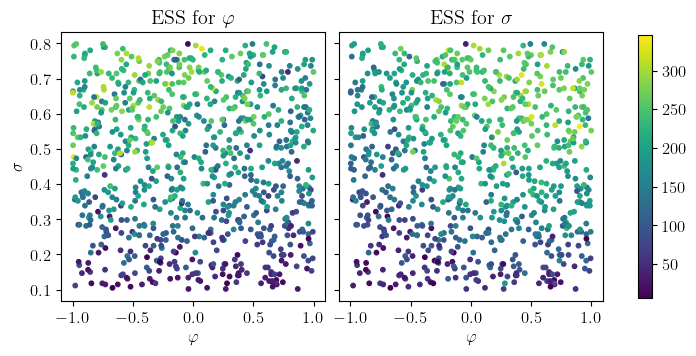

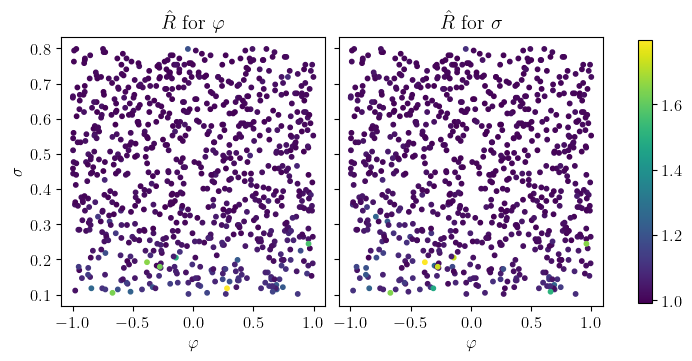

In [26]:
# Plot ESS in parameter space
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), sharex=True, sharey=True)
ax[0].scatter(phi_true[:, 0, 0], phi_true[:, 0, 1], c=ess[:, 0], s=10)
ax[0].set_xlabel(r'$\varphi$')
ax[0].set_ylabel(r'$\sigma$')
ax[0].set_title(r'ESS for $\varphi$')
ax[1].scatter(phi_true[:, 0, 0], phi_true[:, 0, 1], c=ess[:, 1], s=10)
ax[1].set_xlabel(r'$\varphi$')
ax[1].set_title(r'ESS for $\sigma$')
fig.subplots_adjust(right=0.9, wspace=0.05)
cbar_ax = fig.add_axes([0.95, 0.12, 0.02, 0.75])
fig.colorbar(ax[0].collections[0], cax=cbar_ax)
if save_fig:
    plt.savefig('output/nat_images_ess.pdf', bbox_inches='tight')
plt.show()

# Plot Rhat in parameter space
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), sharex=True, sharey=True)
ax[0].scatter(phi_true[:, 0, 0], phi_true[:, 0, 1], c=rhat[:, 0], s=10)
ax[0].set_xlabel(r'$\varphi$')
ax[0].set_ylabel(r'$\sigma$')
ax[0].set_title(r'$\hat{R}$ for $\varphi$')
ax[1].scatter(phi_true[:, 0, 0], phi_true[:, 0, 1], c=rhat[:, 1], s=10)
ax[1].set_xlabel(r'$\varphi$')
ax[1].set_title(r'$\hat{R}$ for $\sigma$')
fig.subplots_adjust(right=0.9, wspace=0.05)
cbar_ax = fig.add_axes([0.95, 0.12, 0.02, 0.75])
fig.colorbar(ax[0].collections[0], cax=cbar_ax)
if save_fig:
    plt.savefig('output/nat_images_rhat.pdf', bbox_inches='tight')
plt.show()

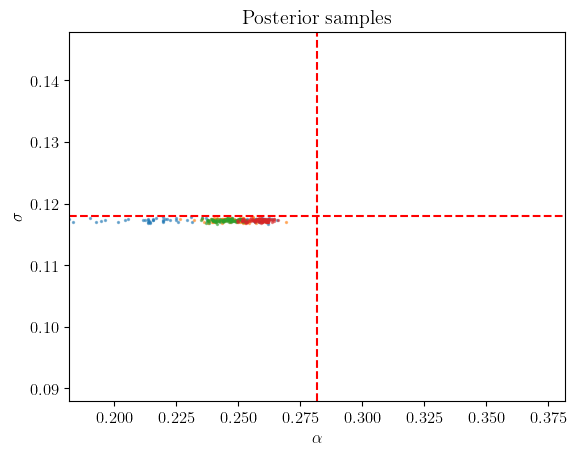

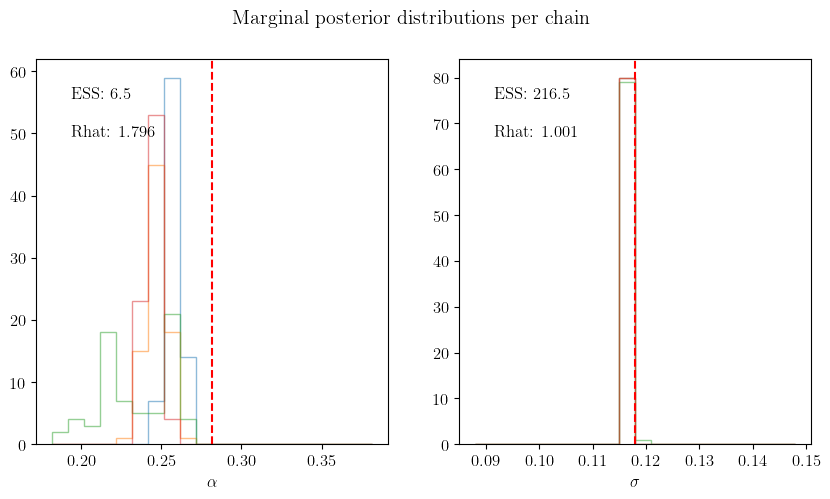

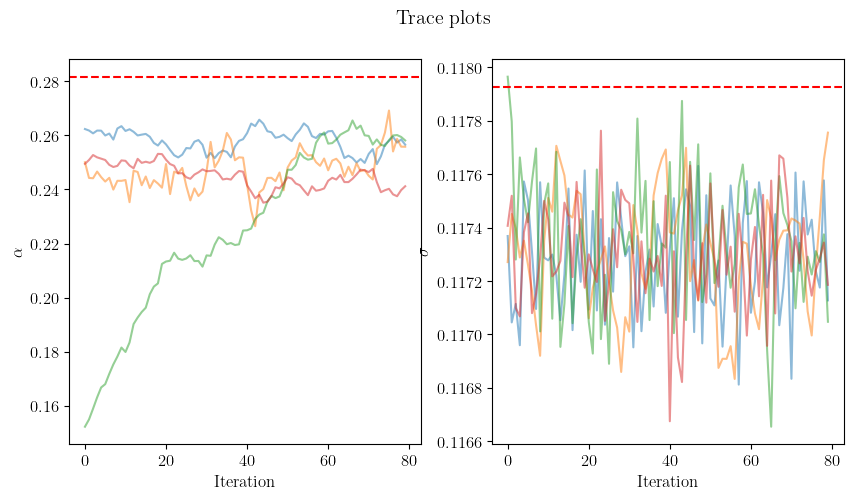

In [27]:
#
# Plot for a random phi_test / posterior estimation
#

i = np.random.randint(0, N)
bad_rhat_indices = np.where(rhat[:, 0] > 1.1)[0]
i = bad_rhat_indices[np.random.randint(0, len(bad_rhat_indices))]

plt.figure()
for j in range(M):
    plt.scatter(phi_all[i, j, :, 0], phi_all[i, j, :, 1], s=2, alpha=0.5)
plt.axvline(phi_true[i, 0, 0], color='red', linestyle='--')
plt.axhline(phi_true[i, 0, 1], color='red', linestyle='--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sigma$")
plt.xlim(phi_true[i, 0, 0] - 0.1, phi_true[i, 0, 0] + 0.1)
plt.ylim(phi_true[i, 0, 1] - 0.03, phi_true[i, 0, 1] + 0.03)
plt.title("Posterior samples")
plt.show()

chains_id = np.random.choice(M, min(M, 5), replace=False)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for j in chains_id:
    axs[0].hist(phi_all[i, j, :, 0], alpha=0.5, bins=20, range=(phi_true[i, 0, 0] - 0.1, phi_true[i, 0, 0] + 0.1), histtype='step')
    axs[1].hist(phi_all[i, j, :, 1], alpha=0.5, bins=20, range=(phi_true[i, 0, 1] - 0.03, phi_true[i, 0, 1] + 0.03), histtype='step')
axs[0].axvline(phi_true[i, 0, 0], color='red', linestyle='--')
axs[1].axvline(phi_true[i, 0, 1], color='red', linestyle='--')
axs[0].set_xlabel(r"$\alpha$")
axs[1].set_xlabel(r"$\sigma$")
for j in range(2):
    xmin, xmax = axs[j].get_xlim()
    ymin, ymax = axs[j].get_ylim()
    axs[j].text(xmin + 0.1*(xmax - xmin), ymax - 0.1*(ymax - ymin), "ESS: {:.1f}".format(ess[i, j]))
    axs[j].text(xmin + 0.1*(xmax - xmin), ymax - 0.2*(ymax - ymin), "Rhat: {:.3f}".format(rhat[i, j]))
plt.suptitle("Marginal posterior distributions per chain")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for j in chains_id:
    axs[0].plot(phi_all[i, j, :, 0], alpha=0.5)
    axs[1].plot(phi_all[i, j, :, 1], alpha=0.5)
axs[0].axhline(phi_true[i, 0, 0], color='red', linestyle='--')
axs[1].axhline(phi_true[i, 0, 1], color='red', linestyle='--')
axs[0].set_xlabel("Iteration")
axs[1].set_xlabel("Iteration")
axs[0].set_ylabel(r"$\alpha$")
axs[1].set_ylabel(r"$\sigma$")
plt.suptitle("Trace plots")
plt.show()

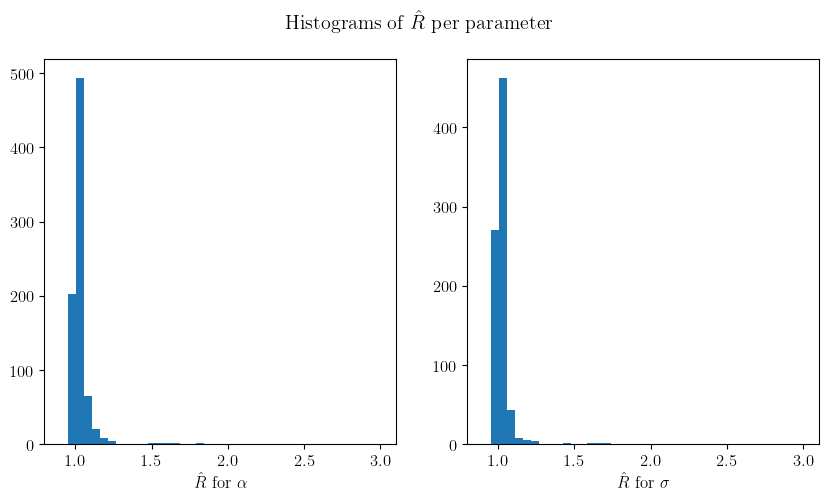

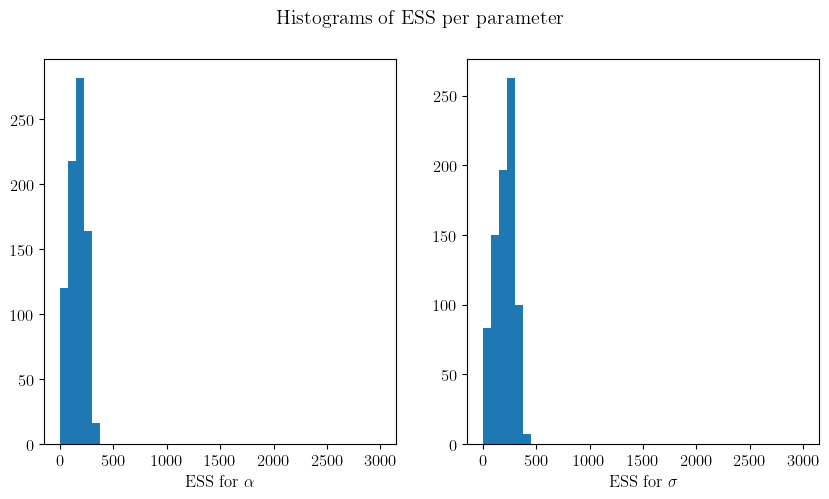

In [28]:
# Plot histograms of Rhat per parameter
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(rhat[:, 0], bins=40, range=(0.9, 3.0))
axs[1].hist(rhat[:, 1], bins=40, range=(0.9, 3.0))
axs[0].set_xlabel(r"$\hat{R}$ for $\alpha$")
axs[1].set_xlabel(r"$\hat{R}$ for $\sigma$")
plt.suptitle("Histograms of $\hat{R}$ per parameter")
plt.show()

# Plot histograms of ESS per parameter
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(ess[:, 0], bins=40, range=(0, 3000))
axs[1].hist(ess[:, 1], bins=40, range=(0, 3000))
axs[0].set_xlabel(r"ESS for $\alpha$")
axs[1].set_xlabel(r"ESS for $\sigma$")
plt.suptitle("Histograms of ESS per parameter")
plt.show()

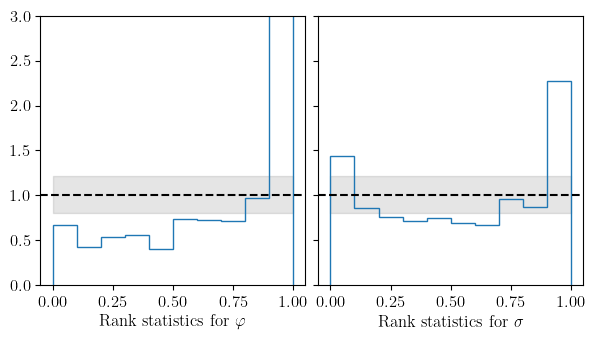

In [29]:
#
# Simulation-based calibration
#

# Compute rank statistics
ranks = np.zeros((N, nparams))
autocorr_length_per_chain = np.zeros((N, nparams))

for i in range(N):
    for j in range(nparams):
        autocorr_length_per_chain[i, j] = N*M / ess[i, j]
        ranks[i, j] = np.mean((phi_all[i, :, ::max(int(autocorr_length_per_chain[i, j]), 1), j].flatten() < phi_true[i, 0, j]).astype(float))

# Plot ranks statistics
labels = [r"$\varphi$", r"$\sigma$"]
nbins = 10
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), sharex=True, sharey=True)
for i in range(2):
    n, bins, _ = axs[i].hist(ranks[:, i], bins=nbins, density=True, histtype='step', range=(0, 1))
    bins_centers = (bins[:-1]+bins[1:])/2
    q0 = binom.ppf(0.025, N, 1.0/nbins) * nbins/N
    q1 = binom.ppf(0.975, N, 1.0/nbins) * nbins/N
    axs[i].axhline(1.0, color='black', linestyle='--')
    axs[i].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
    axs[i].set_xlabel(f"Rank statistics for {labels[i]}")
axs[0].set_ylim([0, 3])
fig.subplots_adjust(wspace=0.05)
if save_fig:
    plt.savefig('output/nat_images_sbc.pdf', bbox_inches='tight')
plt.show()